# RTML lab2 report - st121413

1. Create VSCode projects for each of these three networks. Be sure to properly define your Python classes, with one class per file and a main module that sets up your objects, runs the training process, and saves the necessary data.

2. Note that the AlexNet implementation here does not have the local response normalization feature described in the paper. Take a look at the PyTorch implementation of LRN and incorporate it into your AlexNet implementation as it is described in the paper. Compare your test set results with and without LRN.

3. Note that the backbone of the GoogLeNet implemented thus far does not correspond exactly to the description. Modify the architecture to
 - A.Use the same backbone (input image size, convolutions, etc.) before the first Inception module
 - B. Add the two side classifiers 
 
4. Compare your GoogLeNet and AlexNet implementations on CIFAR-10. Comment on the number of parameters, speed of training, and accuracy of the two models on this dataset when trained from scratch.

5. Experiment with the pretrained GoogLeNet from the torchvision repository. Does it give better results on CIFAR-10 similar to what we found with AlexNet last week? Comment on what we can glean from the results about the capacity and generalization ability of these two models.

In [1]:
##### Prerequisite code ####### 

# import pickle
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

import torch
import torchvision
from torchvision import datasets, models, transforms

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=preprocess)
testloader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=False, num_workers=0)

import numpy as np
classes = np.array(('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'))


def CIFARTest(model,testloader):
    model.eval()
    #Testing Accuracy
    correct = 0
    total = 0
    #Testing classification accuracy for individual classes.
    class_correct = np.zeros(10)
    class_total = np.zeros(10)
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # print(labels)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))
    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))


Files already downloaded and verified


## 1. Create VSCode projects for each of these three networks. 
*Be sure to properly define your Python classes, with one class per file and a main module that sets up your objects, runs the training process, and saves the necessary data.*

For this task, the  three models has the followings files
 
1. .ipynb for developing and testing
 2. .py for running nohup
 3. .out for collect result printed from nohup
 4. *loss*.txt and *val*.txt for collect loss in pickle format
 5. .pth the best model so far (not in Git because of size)
 6. myModule.py if that model develop using extend from python module

https://github.com/akraradets/2021JanRTML/tree/main/lab2


## 2. Alexnet (sequential)
Take a look at the PyTorch implementation of LRN and incorporate it into your AlexNet implementation as it is described in the paper. Compare your test set results with and without LRN.

For this task, I used 
 - batch_size = 4
 - train/val split = [40000, 10000]
 - Preprocess: resize=256|CenterCrop=224|Norm=(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
 - Loss Function = CrossEntropyLoss() 
 - optimizer = SGD with LR=0.001|momentum=0.9
 - epoch = 10

In [ ]:
# AlexNet-like model using the Sequential API
NUM_CLASSES = 10
alexnet_sequential = nn.Sequential(
    # Layer 1
    nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
    nn.ReLU(inplace=True),
    ### LRN1 ###
    nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2.0),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # Layer 2
    nn.Conv2d(96, 256, kernel_size=5, padding=2),
    nn.ReLU(inplace=True),
    ## LRN2 ###
    nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2.0),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # Layer 3
    nn.Conv2d(256, 384, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    # Layer 4
    nn.Conv2d(384, 384, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    # Layer 5
    nn.Conv2d(384, 256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # Layer 6
    nn.AdaptiveAvgPool2d((6, 6)),
    Flatten(),
    # Layer 7
    nn.Dropout(),
    nn.Linear(256 * 6 * 6, 4096),
    nn.ReLU(inplace=True),
    # Layer 8
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    # Layer 9
    nn.Linear(4096, NUM_CLASSES)
)

*During creating the report, I noticed that the training function gave ny Prof. Matt did not return accuracy and loss of both training and valiadation phase*

*It is good that I save the print text of each run in .out*

*Next time, I will create a graph more elegantly*

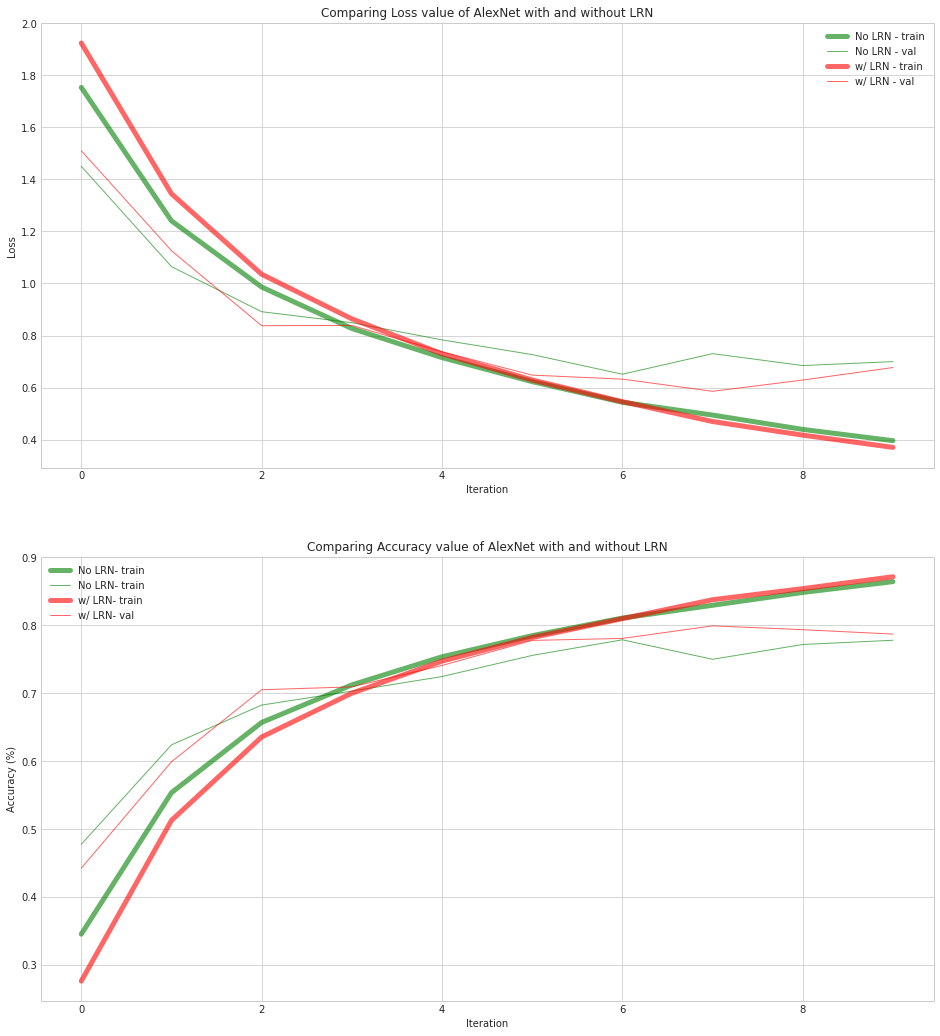

In [42]:
fig, ax = plt.subplots(2, figsize=(16,18))
##### What suppose to be elegant #######
# with open("./AlexNet/alexLRN_loss_acc_history.txt", 'rb') as handle:
#     data = pickle.load(handle)
# ax.plot(data, label="w/ LRN - train loss", c='g', lw=5, alpha=0.6)

# with open("./AlexNet/alexLRN_val_acc_history.txt", 'rb') as handle:
#     data = pickle.load(handle)
# ax.plot(data, label="w/ LRN - val loss", c='g', lw=1, alpha=0.6)

alex_train_loss = [1.7535,1.2407,0.9864,0.8271,0.7152,0.6228,0.5436,0.4943,0.4392,0.3959]
alex_train_acc = [0.3455,0.5537,0.6571,0.7124,0.7538,0.7849,0.8108,0.8296,0.8485,0.8644]
alex_val_loss = [1.4502,1.0649,0.8915,0.8494,0.7833,0.7267,0.6513,0.7304,0.6846,0.6997]
alex_val_acc = [0.4778,0.6241,0.6827,0.7033,0.7247,0.7558,0.7788,0.7501,0.7719,0.7781]

alexlrn_train_loss = [1.9240,1.3448,1.0355,0.8641,0.7297,0.6292,0.5459,0.4695,0.4172,0.3702]
alexlrn_train_acc = [0.2764,0.5129,0.6357,0.7002,0.7474,0.7821,0.8099,0.8378,0.8541,0.8716]
alexlrn_val_loss = [1.5101,1.1260,0.8378,0.8388,0.7376,0.6478,0.6325,0.5856,0.6289,0.6770]
alexlrn_val_acc = [0.4426,0.5992,0.7053,0.7095,0.7410,0.7779,0.7808,0.7993,0.7937,0.7872]

ax[0].plot(alex_train_loss, label="No LRN - train", c='g', lw=5, alpha=0.6)
ax[0].plot(alex_val_loss, label="No LRN - val", c='g', lw=1, alpha=0.6)
ax[0].plot(alexlrn_train_loss, label="w/ LRN - train", c='r', lw=5, alpha=0.6)
ax[0].plot(alexlrn_val_loss, label="w/ LRN - val", c='r', lw=1, alpha=0.6)
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Loss')
ax[0].set_title('Comparing Loss value of AlexNet with and without LRN')
ax[0].legend()

ax[1].plot(alex_train_acc, label="No LRN- train", c='g', lw=5, alpha=0.6)
ax[1].plot(alex_val_acc, label="No LRN- train", c='g', lw=1, alpha=0.6)
ax[1].plot(alexlrn_train_acc, label="w/ LRN- train", c='r', lw=5, alpha=0.6)
ax[1].plot(alexlrn_val_acc, label="w/ LRN- val", c='r', lw=1, alpha=0.6)
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title('Comparing Accuracy value of AlexNet with and without LRN')
ax[1].legend()

plt.show()


In [77]:
import torch.nn as nn

class Flatten(nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)
# AlexNet-like model using the Sequential API
NUM_CLASSES = 10
model = nn.Sequential(
    nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(96, 256, kernel_size=5, padding=2),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(256, 384, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(384, 384, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(384, 256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.AdaptiveAvgPool2d((6, 6)),
    Flatten(),
    nn.Dropout(),
    nn.Linear(256 * 6 * 6, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Linear(4096, NUM_CLASSES)
)
model.load_state_dict(torch.load('./AlexNet/alex_sequential_lr_0.001_bestsofar.pth'))
model.eval()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = model.to(device)

CIFARTest(model,testloader)

Accuracy of the network on the 10000 test images: 78 %
Accuracy of plane : 78 %
Accuracy of   car : 90 %
Accuracy of  bird : 69 %
Accuracy of   cat : 66 %
Accuracy of  deer : 80 %
Accuracy of   dog : 64 %
Accuracy of  frog : 85 %
Accuracy of horse : 82 %
Accuracy of  ship : 81 %
Accuracy of truck : 85 %


In [75]:

# AlexNet-like model using the Sequential API
NUM_CLASSES = 10
model = nn.Sequential(
    # Layer 1
    nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
    nn.ReLU(inplace=True),
    ### LRN1 ###
    nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2.0),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # Layer 2
    nn.Conv2d(96, 256, kernel_size=5, padding=2),
    nn.ReLU(inplace=True),
    ## LRN2 ###
    nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2.0),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # Layer 3
    nn.Conv2d(256, 384, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    # Layer 4
    nn.Conv2d(384, 384, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    # Layer 5
    nn.Conv2d(384, 256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # Layer 6
    nn.AdaptiveAvgPool2d((6, 6)),
    Flatten(),
    # Layer 7
    nn.Dropout(),
    nn.Linear(256 * 6 * 6, 4096),
    nn.ReLU(inplace=True),
    # Layer 8
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    # Layer 9
    nn.Linear(4096, NUM_CLASSES)
)
model.load_state_dict( torch.load('./AlexNet/alex_sequential_LRN_lr_0.001_bestsofar.pth'), strict=False)
model.eval()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = model.to(device)

CIFARTest(model,testloader)

Accuracy of the network on the 10000 test images: 80 %
Accuracy of plane : 84 %
Accuracy of   car : 89 %
Accuracy of  bird : 65 %
Accuracy of   cat : 69 %
Accuracy of  deer : 81 %
Accuracy of   dog : 64 %
Accuracy of  frog : 85 %
Accuracy of horse : 84 %
Accuracy of  ship : 86 %
Accuracy of truck : 86 %


Last but not least.

- Training time of AlexNet with out LRN is  28m 33s
- Training time of AlexNet with LRN is      31m 15s


Conclusion: The 1-2% gain in accuracy and complexity increase is seem to be the same as the paper

## 3. Note that the backbone of the GoogLeNet implemented thus far does not correspond exactly to the description. Modify the architecture to
 - A. Use the same backbone (input image size, convolutions, etc.) before the first Inception module
 - B. Add the two side classifiers 

I have two implementation of GoogLeNet

1. https://github.com/akraradets/2021JanRTML/blob/main/lab2/GoogleNet/myModule.py
2. https://github.com/akraradets/2021JanRTML/blob/main/lab2/GoogleNet/myModulePaper.py

Since the inception class is given, the 'myModule.py' is using the inception as is.
Later, Chaichan found that thet conv 5x5 layer is changed to two of conv 3x3. I am curious about "the paper" performace which use 5x5 conv and no BatchNorm. Therefore, I modified the inception to be the same as the paper which shown in 'myModulePaper.py'

The rest of the model are the same.

### A.
The modified 'before inception' backbone is the 'PreLayer' class. It completely follows the paper so it accpects input size of 224x224

### B.
The side classifiers are "Aux4A" and "Aux4D"

No softmax is used because pytorch CorssEntropy already used logSoftMax in it. 

In [ ]:
class Aux4A(nn.Module):
    def __init__(self):
        super(Aux4A, self).__init__()
        self.conv = nn.Sequential(
            # torch.Size([4, 512, 14, 14])
            # An average pooling layer with 5×5 filter size and stride 3, 
            # resulting in an 4×4×512 output for the (4a)
            nn.AvgPool2d(kernel_size=5,stride=3,padding=0),
            # A 1×1 convolution with 128 filters for dimension reduction and rectified linear activation
            nn.Conv2d(in_channels=512,out_channels=128,kernel_size=1,stride=1),
            nn.ReLU(inplace=True),
            # torch.Size([4, 128, 4, 4])
        )
        self.fc = nn.Sequential(
            # torch.Size([4, 128, 4, 4])
            # A fully connected layer with 1024 units and rectified linear activation.
            nn.Linear(in_features=128 * 4 * 4,out_features=1024),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=1024,out_features=1024),
            nn.ReLU(inplace=True),
            # A dropout layer with 70% ratio of dropped outputs.
            nn.Dropout2d(p=0.7),
            # A linear layer with softmax loss as the classifier (predicting the same 1000 classes as the main classifier, but removed at inference time).
            nn.Linear(in_features=1024,out_features=10),
            # nn.Softmax()
        )

    def forward(self, x):
        out = self.conv(x)
        out = self.fc(out.flatten(start_dim=1))
        return out


class Aux4D(nn.Module):
    def __init__(self):
        super(Aux4D, self).__init__()
        self.conv = nn.Sequential(
            # torch.Size([4, 528, 14, 14])
            # An average pooling layer with 5×5 filter size and stride 3, 
            # resulting in an 4×4×528 output for the (4d)
            nn.AvgPool2d(kernel_size=5,stride=3,padding=0),
            # A 1×1 convolution with 128 filters for dimension reduction and rectified linear activation
            nn.Conv2d(in_channels=528,out_channels=128,kernel_size=1,stride=1),
            nn.ReLU(inplace=True),
            # torch.Size([4, 128, 4, 4])
        )
        self.fc = nn.Sequential(
            # torch.Size([4, 128, 4, 4])
            # A fully connected layer with 1024 units and rectified linear activation.
            nn.Linear(in_features=128 * 4 * 4,out_features=1024),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=1024,out_features=1024),
            nn.ReLU(inplace=True),
            # A dropout layer with 70% ratio of dropped outputs.
            nn.Dropout2d(p=0.7),
            # A linear layer with softmax loss as the classifier (predicting the same 1000 classes as the main classifier, but removed at inference time).
            nn.Linear(in_features=1024,out_features=10),
            # nn.Softmax()
        )

    def forward(self, x):
        out = self.conv(x)
        out = self.fc(out.flatten(start_dim=1))
        return out

class PreLayer(nn.Module):
    def __init__(self):
        super(PreLayer, self).__init__()
        self.pre_layers = nn.Sequential(
            # nn.Conv2d(3, 192, kernel_size=3, padding=1),
            # nn.BatchNorm2d(192),
            # nn.ReLU(True),

            # Follow GoogLeNet Implementation
            # Note: remove BatchNorm2d because it is not used in the paper
            # 1. Conv 224x224x3 -> 112x112x64
            nn.Conv2d(3, 64, kernel_size=7,stride=2,padding=3),
            nn.ReLU(inplace=True),
            # 2. MaxPool 112x112x64 -> 56x56x64
            nn.MaxPool2d(kernel_size=3,stride=2,padding=0),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2.0),
            # 3. Conv 56x56x64 -> 56x56x192
            ### 3x3red
            nn.Conv2d(64, 64, kernel_size=1),
            ### 3x3 
            nn.Conv2d(64,192, kernel_size=3,stride=1,padding=1),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2.0),
            # 4. MaxPool 56x56x192 -> 28x28x192
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        )

    def forward(self, x):
        out = self.pre_layers(x)
        return out

class GoogLeNet(nn.Module):

    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.pre_layers = PreLayer()

        self.a3 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        # torch.Size([4, 512, 14, 14])
        self.aux4a = Aux4A()
        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)
        
        self.aux4d = Aux4D()
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
        # self.linear = nn.Linear(1024, 10)
        self.fc = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=1024,out_features=10),
            # nn.Softmax()
        )

    def forward(self, x):
        out = self.pre_layers(x)
        out = self.a3(out)
        out = self.b3(out)
        out = self.maxpool(out)
        out = self.a4(out)

        out_aux4a = self.aux4a(out)
        out = self.b4(out)
        
        out = self.c4(out)
        out = self.d4(out)
        # print("d4", out.shape)

        out_aux4d = self.aux4d(out)
        out = self.e4(out)

        out = self.maxpool(out)
        out = self.a5(out)
        out = self.b5(out)
        out = self.avgpool(out)
        # print(out.shape)
        out = self.fc(out.flatten(start_dim=1))
        # print("out",out.shape)
        # out = out.view(out.size(0), -1)
        # out = self.linear(out)
        
        if(self.training):
            return out, out_aux4a, out_aux4d
        else:
            return out

## 4. Compare your GoogLeNet and AlexNet implementations on CIFAR-10. Comment on the number of parameters, speed of training, and accuracy of the two models on this dataset when trained from scratch.

## 5. Experiment with the pretrained GoogLeNet from the torchvision repository. Does it give better results on CIFAR-10 similar to what we found with AlexNet last week? Comment on what we can glean from the results about the capacity and generalization ability of these two models.

I am going to answer both question at the same time. WOWWWWW

The models I have trained and will be compared in this section is the followings

 1. AlexNetModule - just AlexNet with LRN but in module form
 2. GoogLeNet - My GoogLeNet implementation using as is inception
 3. GoogLeNet Pretrain - The downloaded pretrain GoogLeNet from torchvision with modified last layer
  - torch.hub.load('pytorch/vision:v0.8.2', 'googlenet', pretrained=True, aux_logits=True)
  - model.fc = nn.Linear(in_features=1024,out_features=10,bias=True)
 4. GoogLeNetPaper - My GoogLeNet implementation using modifed inception

### Number of parameters
I use this code for finding the parameter number

<code>print(sum(p.numel() for p in model.parameters() if p.requires_grad))</code>

 1. AlexNetModule: 57,044,810
 2. GoogLeNet: 12,734,334
 3. GoogLeNet Pretrain: 11,990,138
 4. GoogLeNetPaper: 12,433,230

I don't think this is the correct way to find yet since I also tried with removed BatchNorm and the parameter count is decreased. Anyhow, it is the only way I found in the internet.

The configuration I used are the followings
 - batch_size=4|worker=2
 - train/val split = [40000, 10000]
 - Loss Function = CrossEntropyLoss() 
 - optimizer = SGD with LR=0.001|momentum=0.9
 - epoch = 50
 - Preprocess
   - No Augmentation: resize=256|CenterCrop=224|Norm=(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
   - With Augmentation: resize=256|"RandomCrop=224"|"RandomHorizontalFlip"|Norm=(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)

### Speed

 1. AlexNetModule:      132m 9s
 2. GoogLeNet:          255m 24s
 3. GoogLeNet Pretrain: 204m 21s 
 4. GoogLeNetPaper:     219m 10s

### Train and Validation Loss/Accuracy

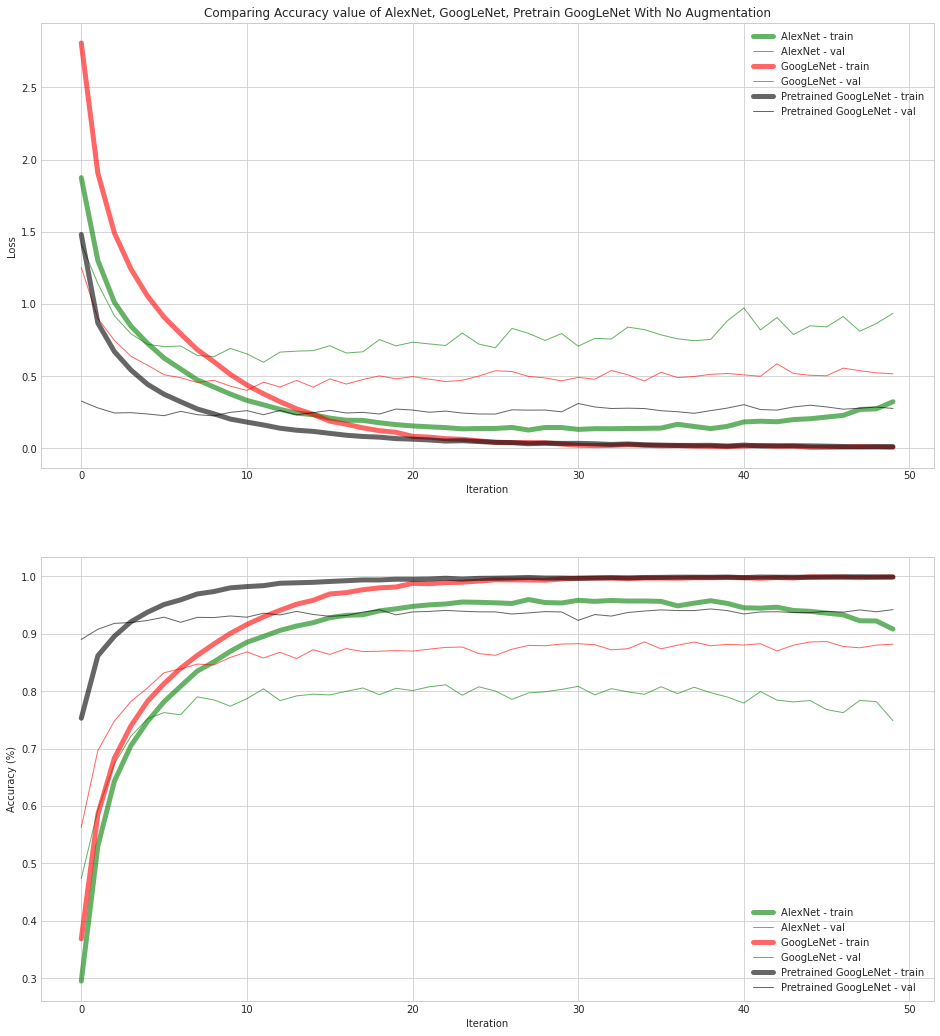

In [81]:
fig, ax = plt.subplots(2, figsize=(16,18))

alex_train_loss = [1.8755,1.3020,1.0126,0.8466,0.7282,0.6260,0.5502,0.4750,0.4258,0.3766,0.3325,0.3025,0.2707,0.2446,0.2337,0.2101,0.1954,0.1943,0.1780,0.1649,0.1560,0.1498,0.1444,0.1357,0.1379,0.1385,0.1455,0.1274,0.1451,0.1448,0.1320,0.1369,0.1366,0.1382,0.1391,0.1410,0.1674,0.1523,0.1375,0.1530,0.1836,0.1886,0.1848,0.2000,0.2058,0.2177,0.2292,0.2700,0.2744,0.3235]
alex_train_acc = [0.2952,0.5303,0.6434,0.7054,0.7474,0.7819,0.8087,0.8350,0.8511,0.8695,0.8853,0.8955,0.9059,0.9136,0.9194,0.9281,0.9322,0.9332,0.9400,0.9435,0.9478,0.9504,0.9520,0.9554,0.9549,0.9540,0.9528,0.9597,0.9545,0.9537,0.9584,0.9565,0.9581,0.9571,0.9572,0.9565,0.9487,0.9534,0.9576,0.9530,0.9454,0.9447,0.9464,0.9406,0.9392,0.9360,0.9331,0.9227,0.9224,0.9083]
google_train_loss = [2.8079,1.9071,1.4923,1.2425,1.0556,0.9089,0.7942,0.6846,0.6016,0.5128,0.4394,0.3787,0.3239,0.2742,0.2361,0.1892,0.1678,0.1425,0.1232,0.1121,0.0837,0.0783,0.0677,0.0633,0.0528,0.0414,0.0406,0.0410,0.0393,0.0306,0.0223,0.0194,0.0210,0.0258,0.0216,0.0187,0.0198,0.0159,0.0147,0.0122,0.0169,0.0203,0.0148,0.0163,0.0075,0.0081,0.0089,0.0137,0.0101,0.0076]
google_train_acc = [0.3687,0.5856,0.6836,0.7398,0.7825,0.8134,0.8400,0.8623,0.8822,0.9007,0.9162,0.9296,0.9410,0.9516,0.9584,0.9694,0.9718,0.9768,0.9801,0.9815,0.9879,0.9873,0.9892,0.9899,0.9919,0.9941,0.9939,0.9938,0.9934,0.9955,0.9970,0.9971,0.9972,0.9961,0.9971,0.9971,0.9969,0.9977,0.9977,0.9981,0.9977,0.9967,0.9980,0.9973,0.9992,0.9990,0.9988,0.9978,0.9985,0.9990]
pregoogle_train_loss = [1.4815,0.8685,0.6706,0.5430,0.4442,0.3753,0.3236,0.2734,0.2401,0.2034,0.1826,0.1626,0.1401,0.1262,0.1182,0.1046,0.0915,0.0831,0.0781,0.0681,0.0641,0.0589,0.0511,0.0536,0.0478,0.0431,0.0404,0.0326,0.0366,0.0350,0.0355,0.0325,0.0279,0.0311,0.0257,0.0232,0.0208,0.0210,0.0218,0.0169,0.0232,0.0174,0.0188,0.0185,0.0178,0.0158,0.0135,0.0099,0.0129,0.0131]
pregoogle_train_acc = [0.7530,0.8618,0.8958,0.9211,0.9377,0.9511,0.9592,0.9694,0.9736,0.9801,0.9823,0.9839,0.9881,0.9889,0.9897,0.9912,0.9925,0.9939,0.9938,0.9951,0.9950,0.9954,0.9968,0.9953,0.9966,0.9969,0.9974,0.9982,0.9972,0.9972,0.9966,0.9973,0.9978,0.9976,0.9981,0.9983,0.9987,0.9986,0.9985,0.9989,0.9979,0.9989,0.9986,0.9986,0.9985,0.9989,0.9992,0.9994,0.9991,0.9990]

alex_val_loss = [1.4173,1.1417,0.9189,0.7944,0.7212,0.7051,0.7096,0.6442,0.6354,0.6924,0.6549,0.5968,0.6673,0.6739,0.6774,0.7114,0.6610,0.6694,0.7541,0.7105,0.7361,0.7241,0.7129,0.7994,0.7229,0.6972,0.8315,0.7971,0.7480,0.7957,0.7083,0.7623,0.7581,0.8406,0.8227,0.7867,0.7591,0.7465,0.7553,0.8836,0.9728,0.8211,0.9066,0.7889,0.8496,0.8419,0.9139,0.8117,0.8653,0.9359]
alex_val_acc = [0.4739,0.5932,0.6736,0.7217,0.7522,0.7628,0.7590,0.7902,0.7850,0.7740,0.7871,0.8042,0.7837,0.7919,0.7949,0.7936,0.7998,0.8057,0.7940,0.8051,0.8012,0.8077,0.8112,0.7931,0.8077,0.8004,0.7859,0.7970,0.7991,0.8032,0.8085,0.7937,0.8045,0.7989,0.7946,0.8079,0.7959,0.8070,0.7974,0.7900,0.7794,0.7994,0.7845,0.7814,0.7838,0.7681,0.7627,0.7841,0.7819,0.7488]
google_val_loss = [1.2533,0.9005,0.7482,0.6385,0.5765,0.5103,0.4898,0.4569,0.4723,0.4315,0.4022,0.4590,0.4254,0.4714,0.4242,0.4816,0.4462,0.4774,0.5028,0.4819,0.4976,0.4801,0.4629,0.4721,0.5016,0.5380,0.5331,0.4991,0.4884,0.4680,0.4925,0.4793,0.5399,0.5104,0.4671,0.5280,0.4907,0.4983,0.5136,0.5192,0.5097,0.4999,0.5863,0.5193,0.5066,0.5036,0.5564,0.5387,0.5238,0.5170]
google_val_acc = [0.5630,0.6967,0.7481,0.7822,0.8058,0.8323,0.8389,0.8473,0.8457,0.8590,0.8685,0.8579,0.8679,0.8569,0.8724,0.8641,0.8743,0.8691,0.8697,0.8708,0.8699,0.8733,0.8763,0.8770,0.8656,0.8626,0.8732,0.8798,0.8793,0.8822,0.8828,0.8810,0.8721,0.8741,0.8859,0.8738,0.8803,0.8857,0.8792,0.8817,0.8805,0.8828,0.8702,0.8803,0.8858,0.8866,0.8779,0.8757,0.8804,0.8820]
pregoogle_val_loss = [0.3280,0.2807,0.2456,0.2480,0.2387,0.2270,0.2571,0.2338,0.2257,0.2499,0.2618,0.2336,0.2634,0.2332,0.2477,0.2637,0.2457,0.2499,0.2384,0.2728,0.2660,0.2508,0.2586,0.2451,0.2386,0.2383,0.2675,0.2653,0.2660,0.2537,0.3113,0.2874,0.2766,0.2789,0.2764,0.2614,0.2543,0.2434,0.2620,0.2796,0.3032,0.2696,0.2655,0.2874,0.2994,0.2876,0.2720,0.2786,0.2868,0.2770]
pregoogle_val_acc = [0.8903,0.9079,0.9182,0.9197,0.9233,0.9290,0.9201,0.9287,0.9283,0.9311,0.9290,0.9359,0.9329,0.9391,0.9337,0.9306,0.9319,0.9379,0.9419,0.9331,0.9381,0.9390,0.9408,0.9393,0.9383,0.9382,0.9345,0.9364,0.9387,0.9381,0.9234,0.9336,0.9309,0.9372,0.9397,0.9417,0.9405,0.9405,0.9433,0.9405,0.9346,0.9381,0.9385,0.9370,0.9370,0.9391,0.9378,0.9416,0.9384,0.9421]


ax[0].plot(alex_train_loss, label="AlexNet - train", c='g', lw=5, alpha=0.6)
ax[0].plot(alex_val_loss, label="AlexNet - val", c='g', lw=1, alpha=0.6)
ax[0].plot(google_train_loss, label="GoogLeNet - train", c='r', lw=5, alpha=0.6)
ax[0].plot(google_val_loss, label="GoogLeNet - val", c='r', lw=1, alpha=0.6)
ax[0].plot(pregoogle_train_loss, label="Pretrained GoogLeNet - train", c='k', lw=5, alpha=0.6)
ax[0].plot(pregoogle_val_loss, label="Pretrained GoogLeNet - val", c='k', lw=1, alpha=0.6)
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Loss')
ax[0].set_title('Comparing Loss value of AlexNet, GoogLeNet, Pretrain GoogLeNet With No Augmentation')
ax[0].legend()

ax[1].plot(alex_train_acc, label="AlexNet - train", c='g', lw=5, alpha=0.6)
ax[1].plot(alex_val_acc, label="AlexNet - val", c='g', lw=1, alpha=0.6)
ax[1].plot(google_train_acc, label="GoogLeNet - train", c='r', lw=5, alpha=0.6)
ax[1].plot(google_val_acc, label="GoogLeNet - val", c='r', lw=1, alpha=0.6)
ax[1].plot(pregoogle_train_acc, label="Pretrained GoogLeNet - train", c='k', lw=5, alpha=0.6)
ax[1].plot(pregoogle_val_acc, label="Pretrained GoogLeNet - val", c='k', lw=1, alpha=0.6)
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Accuracy (%)')
ax[0].set_title('Comparing Accuracy value of AlexNet, GoogLeNet, Pretrain GoogLeNet With No Augmentation')
ax[1].legend()

plt.show()

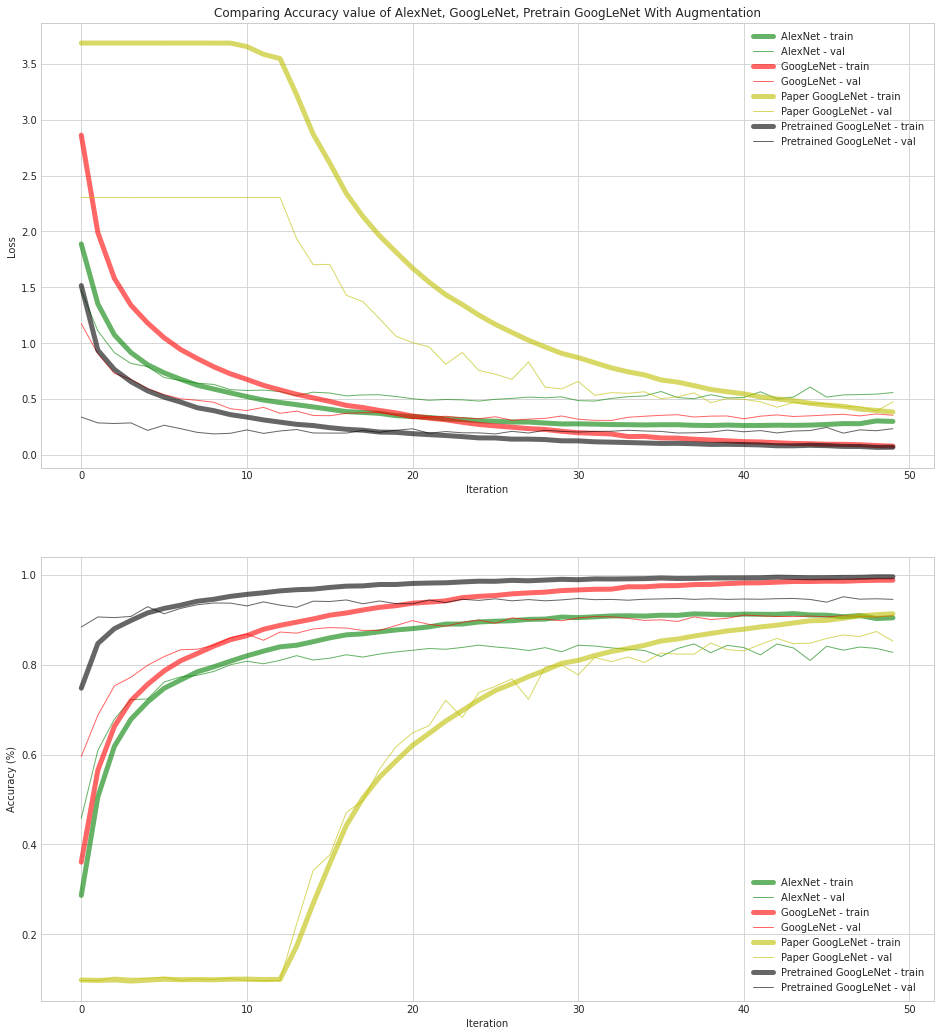

In [85]:
fig, ax = plt.subplots(2, figsize=(16,18))

alex_train_loss = [1.8873,1.3514,1.0735,0.9156,0.8076,0.7345,0.6771,0.6242,0.5893,0.5552,0.5218,0.4909,0.4692,0.4495,0.4294,0.4086,0.3879,0.3802,0.3718,0.3514,0.3435,0.3354,0.3224,0.3162,0.3062,0.3012,0.2942,0.2942,0.2854,0.2775,0.2781,0.2754,0.2719,0.2704,0.2686,0.2702,0.2703,0.2650,0.2636,0.2673,0.2634,0.2639,0.2660,0.2648,0.2669,0.2724,0.2801,0.2797,0.3043,0.2999]
alex_train_acc = [0.2866,0.5059,0.6185,0.6788,0.7170,0.7475,0.7661,0.7841,0.7954,0.8079,0.8198,0.8303,0.8399,0.8434,0.8513,0.8598,0.8665,0.8687,0.8733,0.8774,0.8804,0.8844,0.8905,0.8906,0.8951,0.8969,0.8979,0.9009,0.9016,0.9061,0.9049,0.9066,0.9086,0.9090,0.9083,0.9102,0.9099,0.9132,0.9123,0.9112,0.9127,0.9123,0.9121,0.9138,0.9108,0.9103,0.9068,0.9094,0.9029,0.9044]
google_train_loss = [2.8610,1.9892,1.5792,1.3394,1.1809,1.0486,0.9430,0.8626,0.7887,0.7258,0.6757,0.6226,0.5817,0.5424,0.5106,0.4789,0.4433,0.4241,0.3979,0.3762,0.3479,0.3295,0.3148,0.2920,0.2725,0.2599,0.2480,0.2356,0.2280,0.2117,0.1989,0.1932,0.1871,0.1648,0.1659,0.1519,0.1504,0.1403,0.1336,0.1267,0.1191,0.1160,0.1087,0.1028,0.1004,0.0957,0.0947,0.0913,0.0840,0.0788]
google_train_acc = [0.3606,0.5652,0.6630,0.7201,0.7561,0.7862,0.8089,0.8249,0.8414,0.8556,0.8648,0.8789,0.8876,0.8948,0.9019,0.9102,0.9152,0.9218,0.9277,0.9314,0.9369,0.9394,0.9422,0.9493,0.9522,0.9541,0.9577,0.9599,0.9616,0.9650,0.9665,0.9679,0.9682,0.9735,0.9734,0.9758,0.9761,0.9784,0.9788,0.9806,0.9820,0.9823,0.9838,0.9852,0.9852,0.9859,0.9857,0.9871,0.9879,0.9881]
pregoogle_train_loss = [1.5156,0.9370,0.7646,0.6552,0.5736,0.5168,0.4729,0.4222,0.3962,0.3605,0.3386,0.3134,0.2934,0.2737,0.2629,0.2438,0.2295,0.2211,0.2046,0.2022,0.1902,0.1816,0.1737,0.1639,0.1525,0.1518,0.1413,0.1415,0.1375,0.1262,0.1259,0.1173,0.1143,0.1109,0.1070,0.1026,0.1039,0.0998,0.0940,0.0951,0.0929,0.0894,0.0819,0.0816,0.0861,0.0830,0.0761,0.0756,0.0677,0.0687]
pregoogle_train_acc = [0.7478,0.8472,0.8803,0.8985,0.9153,0.9253,0.9325,0.9413,0.9457,0.9521,0.9566,0.9601,0.9644,0.9670,0.9682,0.9720,0.9749,0.9755,0.9786,0.9786,0.9809,0.9818,0.9824,0.9843,0.9859,0.9857,0.9878,0.9868,0.9884,0.9901,0.9892,0.9910,0.9908,0.9912,0.9916,0.9929,0.9919,0.9921,0.9931,0.9931,0.9933,0.9935,0.9950,0.9943,0.9936,0.9938,0.9944,0.9946,0.9958,0.9958]
papergoogle_train_loss = [3.6851,3.6851,3.6851,3.6852,3.6852,3.6849,3.6851,3.6850,3.6849,3.6845,3.6534,3.5843,3.5461,3.2228,2.8697,2.6118,2.3397,2.1336,1.9619,1.8145,1.6715,1.5456,1.4335,1.3458,1.2511,1.1679,1.0962,1.0259,0.9661,0.9090,0.8707,0.8247,0.7791,0.7438,0.7162,0.6707,0.6514,0.6198,0.5856,0.5654,0.5465,0.5192,0.5016,0.4846,0.4623,0.4456,0.4352,0.4103,0.3981,0.3842]
papergoogle_train_acc = [0.0984,0.0976,0.0985,0.0960,0.0981,0.1002,0.0991,0.0993,0.0989,0.1001,0.1004,0.0993,0.0998,0.1734,0.2687,0.3574,0.4422,0.5030,0.5495,0.5857,0.6207,0.6473,0.6746,0.6981,0.7218,0.7426,0.7575,0.7735,0.7874,0.8032,0.8097,0.8204,0.8294,0.8361,0.8432,0.8528,0.8573,0.8639,0.8695,0.8753,0.8791,0.8841,0.8880,0.8930,0.8978,0.8987,0.9036,0.9088,0.9113,0.9135]


alex_val_loss = [1.4693,1.1097,0.9153,0.8180,0.7911,0.6923,0.6662,0.6422,0.6309,0.5845,0.5766,0.5800,0.5671,0.5305,0.5614,0.5538,0.5285,0.5368,0.5384,0.5226,0.5027,0.4888,0.4959,0.4927,0.4818,0.4976,0.5058,0.5174,0.5115,0.5191,0.4857,0.4821,0.5052,0.5208,0.5279,0.5676,0.5134,0.5031,0.5389,0.5099,0.5143,0.5650,0.5030,0.5175,0.6075,0.5173,0.5372,0.5398,0.5442,0.5577]
alex_val_acc = [0.4584,0.6094,0.6789,0.7224,0.7238,0.7615,0.7729,0.7765,0.7850,0.8000,0.8077,0.8022,0.8097,0.8202,0.8106,0.8145,0.8222,0.8171,0.8238,0.8285,0.8322,0.8361,0.8344,0.8385,0.8436,0.8395,0.8365,0.8316,0.8380,0.8289,0.8434,0.8416,0.8375,0.8345,0.8318,0.8183,0.8362,0.8463,0.8268,0.8432,0.8382,0.8220,0.8462,0.8373,0.8095,0.8412,0.8324,0.8394,0.8363,0.8276]
google_val_loss = [1.1738,0.9053,0.7290,0.6763,0.5945,0.5397,0.5022,0.4887,0.4712,0.4134,0.3973,0.4255,0.3729,0.3917,0.3528,0.3509,0.3717,0.3773,0.3785,0.3536,0.3237,0.3381,0.3461,0.3323,0.3243,0.3417,0.3104,0.3203,0.3274,0.3484,0.3195,0.3096,0.3083,0.3366,0.3462,0.3543,0.3599,0.3390,0.3471,0.3485,0.3234,0.3466,0.3581,0.3437,0.3497,0.3574,0.3636,0.3492,0.3668,0.3549]
google_val_acc = [0.5959,0.6876,0.7529,0.7723,0.7988,0.8180,0.8335,0.8345,0.8430,0.8601,0.8685,0.8544,0.8728,0.8703,0.8796,0.8827,0.8816,0.8764,0.8766,0.8872,0.8982,0.8898,0.8856,0.8943,0.8995,0.8921,0.9044,0.8999,0.9014,0.8977,0.9042,0.9071,0.9066,0.9032,0.8987,0.9000,0.8963,0.9065,0.9006,0.9034,0.9105,0.9089,0.9074,0.9071,0.9083,0.9066,0.9090,0.9075,0.9063,0.9094]
pregoogle_val_loss = [0.3389,0.2866,0.2813,0.2865,0.2196,0.2654,0.2349,0.2020,0.1881,0.1937,0.2238,0.1928,0.2144,0.2273,0.1965,0.1954,0.1957,0.2190,0.2026,0.2205,0.2341,0.1940,0.2093,0.1982,0.1974,0.1881,0.2110,0.1963,0.2208,0.2108,0.2049,0.2105,0.2118,0.2209,0.2140,0.2104,0.1961,0.1981,0.2040,0.2223,0.2072,0.2180,0.1968,0.2137,0.2184,0.2463,0.1948,0.2241,0.2167,0.2348]
pregoogle_val_acc = [0.8840,0.9063,0.9049,0.9075,0.9291,0.9135,0.9254,0.9334,0.9374,0.9371,0.9309,0.9399,0.9326,0.9278,0.9414,0.9407,0.9442,0.9356,0.9419,0.9359,0.9357,0.9440,0.9383,0.9457,0.9432,0.9467,0.9422,0.9450,0.9423,0.9443,0.9474,0.9448,0.9454,0.9436,0.9458,0.9465,0.9475,0.9455,0.9468,0.9455,0.9462,0.9458,0.9470,0.9475,0.9453,0.9392,0.9513,0.9459,0.9468,0.9455]
papergoogle_val_loss = [2.3035,2.3030,2.3030,2.3025,2.3033,2.3028,2.3032,2.3035,2.3034,2.3030,2.3033,2.3035,2.3030,1.9362,1.7019,1.7051,1.4286,1.3713,1.2195,1.0619,1.0044,0.9667,0.8111,0.9166,0.7557,0.7223,0.6758,0.8319,0.6067,0.5908,0.6582,0.5330,0.5572,0.5515,0.5651,0.5038,0.5199,0.5552,0.4676,0.5037,0.4972,0.4750,0.4270,0.4679,0.4569,0.4596,0.4307,0.4316,0.3932,0.4740]
papergoogle_val_acc = [0.0973,0.0968,0.1048,0.1024,0.1024,0.1048,0.0973,0.1010,0.0995,0.1022,0.0968,0.0968,0.0973,0.2228,0.3423,0.3764,0.4712,0.4975,0.5675,0.6175,0.6484,0.6645,0.7210,0.6825,0.7381,0.7520,0.7686,0.7230,0.7950,0.7992,0.7775,0.8163,0.8069,0.8171,0.8051,0.8257,0.8237,0.8237,0.8482,0.8334,0.8307,0.8453,0.8586,0.8469,0.8480,0.8584,0.8662,0.8627,0.8740,0.8528]

ax[0].plot(alex_train_loss, label="AlexNet - train", c='g', lw=5, alpha=0.6)
ax[0].plot(alex_val_loss, label="AlexNet - val", c='g', lw=1, alpha=0.6)
ax[0].plot(google_train_loss, label="GoogLeNet - train", c='r', lw=5, alpha=0.6)
ax[0].plot(google_val_loss, label="GoogLeNet - val", c='r', lw=1, alpha=0.6)
ax[0].plot(papergoogle_train_loss, label="Paper GoogLeNet - train", c='y', lw=5, alpha=0.6)
ax[0].plot(papergoogle_val_loss, label="Paper GoogLeNet - val", c='y', lw=1, alpha=0.6)
ax[0].plot(pregoogle_train_loss, label="Pretrained GoogLeNet - train", c='k', lw=5, alpha=0.6)
ax[0].plot(pregoogle_val_loss, label="Pretrained GoogLeNet - val", c='k', lw=1, alpha=0.6)
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Loss')
ax[0].set_title('Comparing Loss value of AlexNet, GoogLeNet, Pretrain GoogLeNet With Augmentation')
ax[0].legend()

ax[1].plot(alex_train_acc, label="AlexNet - train", c='g', lw=5, alpha=0.6)
ax[1].plot(alex_val_acc, label="AlexNet - val", c='g', lw=1, alpha=0.6)
ax[1].plot(google_train_acc, label="GoogLeNet - train", c='r', lw=5, alpha=0.6)
ax[1].plot(google_val_acc, label="GoogLeNet - val", c='r', lw=1, alpha=0.6)
ax[1].plot(papergoogle_train_acc, label="Paper GoogLeNet - train", c='y', lw=5, alpha=0.6)
ax[1].plot(papergoogle_val_acc, label="Paper GoogLeNet - val", c='y', lw=1, alpha=0.6)
ax[1].plot(pregoogle_train_acc, label="Pretrained GoogLeNet - train", c='k', lw=5, alpha=0.6)
ax[1].plot(pregoogle_val_acc, label="Pretrained GoogLeNet - val", c='k', lw=1, alpha=0.6)
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Accuracy (%)')
ax[0].set_title('Comparing Accuracy value of AlexNet, GoogLeNet, Pretrain GoogLeNet With Augmentation')
ax[1].legend()

plt.show()

### Evaluation

In [92]:
from AlexNetModule.myModule import AlexNetModule

model = AlexNetModule()
model.load_state_dict( torch.load('./AlexNetModule/alex_module_LRN_lr_0.001_bestsofar.pth'), strict=False)
model.eval()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = model.to(device)

CIFARTest(model,testloader)

model = AlexNetModule()
model.load_state_dict( torch.load('./AlexNetModule/alex_module_augment_LRN_lr_0.001_bestsofar.pth'), strict=False)
model.eval()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = model.to(device)

CIFARTest(model,testloader)

Accuracy of the network on the 10000 test images: 80 %
Accuracy of plane : 84 %
Accuracy of   car : 90 %
Accuracy of  bird : 67 %
Accuracy of   cat : 59 %
Accuracy of  deer : 82 %
Accuracy of   dog : 80 %
Accuracy of  frog : 85 %
Accuracy of horse : 84 %
Accuracy of  ship : 86 %
Accuracy of truck : 84 %
Accuracy of the network on the 10000 test images: 85 %
Accuracy of plane : 86 %
Accuracy of   car : 95 %
Accuracy of  bird : 73 %
Accuracy of   cat : 69 %
Accuracy of  deer : 89 %
Accuracy of   dog : 79 %
Accuracy of  frog : 90 %
Accuracy of horse : 88 %
Accuracy of  ship : 93 %
Accuracy of truck : 87 %


In [5]:
from GoogleNet.myModule import GoogLeNet

model = GoogLeNet()
model.load_state_dict( torch.load('./GoogleNet/google_scratch_lr_0.001_bestsofar.pth'), strict=False)
model.eval()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = model.to(device)

CIFARTest(model,testloader)

model = GoogLeNet()
model.load_state_dict( torch.load('./GoogleNet/google_scratch_augment_lr_0.001_bestsofar.pth'), strict=False)
model.eval()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = model.to(device)

CIFARTest(model,testloader)

Accuracy of the network on the 10000 test images: 88 %
Accuracy of plane : 87 %
Accuracy of   car : 95 %
Accuracy of  bird : 82 %
Accuracy of   cat : 75 %
Accuracy of  deer : 88 %
Accuracy of   dog : 84 %
Accuracy of  frog : 92 %
Accuracy of horse : 90 %
Accuracy of  ship : 95 %
Accuracy of truck : 90 %
Accuracy of the network on the 10000 test images: 91 %
Accuracy of plane : 90 %
Accuracy of   car : 96 %
Accuracy of  bird : 88 %
Accuracy of   cat : 78 %
Accuracy of  deer : 93 %
Accuracy of   dog : 88 %
Accuracy of  frog : 93 %
Accuracy of horse : 94 %
Accuracy of  ship : 92 %
Accuracy of truck : 94 %


In [4]:
from GoogleNet.myModulePaper import GoogLeNet

model = GoogLeNet()
model.load_state_dict( torch.load('./GoogleNet/google_scratch_augment_paper_lr_0.001_bestsofar.pth'), strict=False)
model.eval()_
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = model.to(device)

CIFARTest(model,testloader)

Accuracy of the network on the 10000 test images: 87 %
Accuracy of plane : 84 %
Accuracy of   car : 91 %
Accuracy of  bird : 78 %
Accuracy of   cat : 75 %
Accuracy of  deer : 89 %
Accuracy of   dog : 82 %
Accuracy of  frog : 90 %
Accuracy of horse : 89 %
Accuracy of  ship : 94 %
Accuracy of truck : 93 %


In [7]:
model = torch.hub.load('pytorch/vision:v0.8.2', 'googlenet', pretrained=True, aux_logits=True)
model.fc = nn.Linear(in_features=1024,out_features=10,bias=True)
model.load_state_dict( torch.load('./GoogleNet/google_pretrain_lr_0.001_bestsofar.pth'), strict=False)
model.eval()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = model.to(device)

CIFARTest(model,testloader)

model = torch.hub.load('pytorch/vision:v0.8.2', 'googlenet', pretrained=True, aux_logits=True)
model.fc = nn.Linear(in_features=1024,out_features=10,bias=True)
model.load_state_dict( torch.load('./GoogleNet/google_pretrain_augment_lr_0.001_bestsofar.pth'), strict=False)
model.eval()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = model.to(device)

CIFARTest(model,testloader)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.8.2
Accuracy of the network on the 10000 test images: 93 %
Accuracy of plane : 96 %
Accuracy of   car : 97 %
Accuracy of  bird : 88 %
Accuracy of   cat : 88 %
Accuracy of  deer : 92 %
Accuracy of   dog : 90 %
Accuracy of  frog : 96 %
Accuracy of horse : 96 %
Accuracy of  ship : 96 %
Accuracy of truck : 96 %
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.8.2
Accuracy of the network on the 10000 test images: 94 %
Accuracy of plane : 96 %
Accuracy of   car : 97 %
Accuracy of  bird : 93 %
Accuracy of   cat : 88 %
Accuracy of  deer : 94 %
Accuracy of   dog : 90 %
Accuracy of  frog : 96 %
Accuracy of horse : 95 %
Accuracy of  ship : 98 %
Accuracy of truck : 96 %


Recall to Lab1 AlexNet - Attempt A

For evaluation of attemptA

Accuracy of the network on the 10000 test images: 88 %

- Accuracy of plane : 90 %
- Accuracy of car : 100 %
- Accuracy of bird : 89 %
- Accuracy of cat : 65 %
- Accuracy of deer : 92 %
- Accuracy of dog : 86 %
- Accuracy of frog : 86 %
- Accuracy of horse : 93 %
- Accuracy of ship : 92 %
- Accuracy of truck : 100 %

### Conclusion

 1. Augmentation
   
  All models seem to get a benefit from augmentation except the pretrain GoogLeNet. It could be that the pretrained model is already generalized enough.

 2. AlexNet vs GoogLeNet

  It is obvious that GoogLeNet has a better accuracy thoughout training and evaluation.
  
  Despite the less number of parameter of GoogLeNet compared to AlexNet, it is slower.

 3. Scratch and Pretrain
  
  Pretrained AlexNet has a better accuracy than scratch AlexNet by 5-6% (94%, 88%)

  Pretrained GoogLeNet has a better accuracy than scratch one by 3% (94%, 91%) when using Augmentation and 5% without augmentation (93%, 88%).

  The "without augmentation" is unfair comparison because the pretrained one must be train with augmented data which does seem to be the same as AlexNet.

 4. GoogLeNet

  GoogLeNet: 12,734,334 -> 255m 24s
  
  GoogLeNet Pretrain: 11,990,138 -> 204m 21s
  
  GoogLeNetPaper: 12,433,230 -> 219m 10s

  I can not interpret this. The paper version is supposed to be slower than the update inception version. I think it might be due to BatchNorm. From the training graph, it seem that GoogLeNet Paper version is not yet converged. It might takes 10 - 15 more epochs to converge which is different from the another that converge since iteration 20 - 30. It is worth the extra computational cost for BatchNorm.

  Of cause, the Pretrain version is the most optimized one, it run the fastest and perform the best.


  